# Bank Marketing Dataset Analysis and Prediction Model

**Disclaimer**: The notebook was originaly the work of data science bootcamp final project, but personally enhanced and refined by me. 
The team consists Muhammad Ilham, Ananda Farhad Habibie, Zara Maghfira and myself.

The dataset was taken from [https://www.kaggle.com/dhirajnirne/bank-marketing](https://www.kaggle.com/dhirajnirne/bank-marketing)

## Preparation

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import sys
import warnings
import pickle

from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
numpy version:  1.20.3
pandas version:  1.3.4
seaborn version:  0.11.2
last run:  2022-01-07 04:51:30


### Loading Dataset

In [4]:
df = pd.read_csv("bank-marketing.csv")
odf = df.copy()

# developer-friendly column names and format
df.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in df.columns.to_list()]

### Variables and Functions

In [5]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
binary_pallete = ['#EF4444', '#10B981']
binary_order = ['No', 'Yes']


def eval_classification(prediction, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=1)
    return {
        'accuracy': round(accuracy_score(y_test, prediction), 2),
        'precision': round(precision_score(y_test, prediction), 2),
        'recall': round(recall_score(y_test, prediction), 2),
        # 'f1': round(f1_score(y_test, prediction), 2),
        # 'auc': round(auc(fpr, tpr), 2),
    }

def remove_outlier_iqr(df, col):
    filtered_entries = np.array([True] * len(df))
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries

    df = df[filtered_entries]
    return df


## Data Information & Description

### Data Sample

In [6]:
df.sample(5, random_state=1)

,age,age_group,eligible,job,salary,marital,education,marital_education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,response
3610,42,4,Y,blue-collar,20000,married,primary,married-primary,yes,no,2519,yes,no,unknown,15,may,262,4,-1,0,unknown,no,0
11677,37,3,Y,technician,60000,married,secondary,married-secondary,yes,no,2209,no,no,unknown,20,jun,167,2,-1,0,unknown,no,0
33018,32,3,Y,admin.,50000,married,secondary,married-secondary,yes,no,923,yes,no,cellular,17,apr,819,4,-1,0,unknown,no,0
44323,53,5,Y,blue-collar,20000,married,primary,married-primary,yes,no,306,no,no,cellular,28,jul,388,3,181,1,success,yes,1
8119,32,3,Y,technician,60000,single,tertiary,single-tertiary,no,no,257,yes,no,unknown,2,jun,183,5,-1,0,unknown,no,0


### Columns Description

| Column | Description | Type |
| --- | ----------- | ------- |
| age | Customer's Age | numerical - discrete |
| age_group | Customer's Age in Group | categorical - ordinal |
| eligible | ? | categorical - binary |
| job | Customer's job or occupation | categorical - nominal |
| salary | Customer's salary | numerical - continuous |
| marital | Customer's marital status | categorical - nominal |
| education | Customer's education level | categorical - ordinal |
| marital_education | marital + education | categorical - nominal |
| targeted | ? | categorical - binary |
| default | ? | categorical - binary |
| balance | Customer's account balance | numerical - continuous |
| housing | Customer has house or not | categorical - binary |
| loan | Customer has loan or not | categorical - binary |
| contact | Customer's Age in Group | categorical - nominal |
| day | The day customer was contacted | categorical - nominal |
| month | The month customer was contacted | categorical - nominal |
| duration | ? | numerical - continuous |
| campaign | The campaign given to the customer | categorical - nominal |
| pdays | ? | numerical - continuous |
| previous | The previous campaign given to the customer | categorical - nominal |
| poutcome | The result on previous campaign | categorical - nominal |
| y | Customer's response. Value in `yes` or `no` | categorical - binary |
| response | Customer's response. Value in `1` or `0` | categorical - binary |

### Data Information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                45211 non-null  int64 
 1   age_group          45211 non-null  int64 
 2   eligible           45211 non-null  object
 3   job                45211 non-null  object
 4   salary             45211 non-null  int64 
 5   marital            45211 non-null  object
 6   education          45211 non-null  object
 7   marital_education  45211 non-null  object
 8   targeted           45211 non-null  object
 9   default            45211 non-null  object
 10  balance            45211 non-null  int64 
 11  housing            45211 non-null  object
 12  loan               45211 non-null  object
 13  contact            45211 non-null  object
 14  day                45211 non-null  int64 
 15  month              45211 non-null  object
 16  duration           45211 non-null  int64

## Preprocessing

### Find Duplicated Data

In [8]:
df.duplicated().sum()

0

There is no duplicated data

### Find Missing Value

In [9]:
df.isna().sum()

age                  0
age_group            0
eligible             0
job                  0
salary               0
marital              0
education            0
marital_education    0
targeted             0
default              0
balance              0
housing              0
loan                 0
contact              0
day                  0
month                0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
y                    0
response             0
dtype: int64

There is no missing value

### Remove Unnecessary Features

In [10]:
pass

### Uniform Binary Features Values

In [11]:
df['eligible'] = df['eligible'].apply(lambda eligible: 'Yes' if eligible == 'Y' else 'No')
df['response'] = df['response'].apply(lambda response: 'Yes' if response == 1 else 'No')
df['targeted'] = df['targeted'].apply(lambda targeted: targeted.title())
df['default'] = df['default'].apply(lambda default: default.title())
df['housing'] = df['housing'].apply(lambda housing: housing.title())
df['loan'] = df['loan'].apply(lambda loan: loan.title())
df['y'] = df['y'].apply(lambda y: y.title())
df['month'] = df['month'].apply(lambda month: month.title())

### Creating Date-like Feature From `month` and `day` (Experimental)

In [12]:
# TODO: find library to simplify the transform
month_mapper = {'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06', 'jul':'07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'}

odf['month_p'] = odf['month'].apply(lambda month: month_mapper[month])
odf['day_p'] = odf['day'].apply(lambda day: str(day) if int(day) > 9 else '0' + str(day))
odf['month_day'] = odf['month_p'] + '-' + odf['day_p']

odf[['month', 'month_p', 'day', 'day_p', 'month_day']].sample(5, random_state=1).sort_values('month_day')

,month,month_p,day,day_p,month_day
33018,apr,04,17,17,04-17
3610,may,05,15,15,05-15
8119,jun,06,2,02,06-02
11677,jun,06,20,20,06-20
44323,jul,07,28,28,07-28


#### 

## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [13]:
df.select_dtypes(include='number').describe()

,age,age_group,salary,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,3.645861,57006.171065,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,1.083271,32085.718415,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,1.000000,0.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,3.000000,20000.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,3.000000,60000.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,4.000000,70000.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,9.000000,120000.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


#### Categorical

In [14]:
df.select_dtypes(exclude='number').describe()

,eligible,job,marital,education,marital_education,targeted,default,housing,loan,contact,month,poutcome,y,response
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,2,12,3,4,12,2,2,2,2,3,12,4,2,2
top,Yes,blue-collar,married,secondary,married-secondary,Yes,No,Yes,No,cellular,May,unknown,No,No
freq,43380,9732,27214,23202,13770,37091,44396,25130,37967,29285,13766,36959,39922,39922


### Univariate Analysis

#### Distribution Plot of Numerical Features

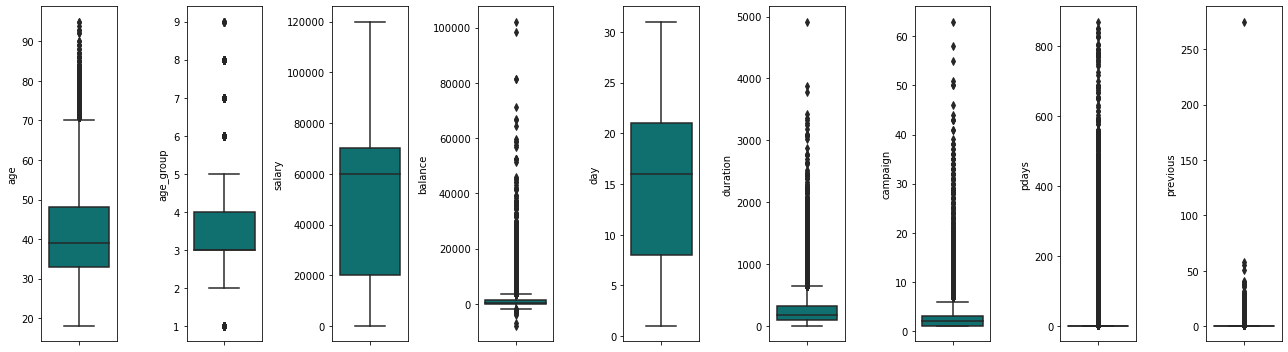

In [15]:
idf = df.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=df[cols[index]], color='teal', orient='v')
    plt.tight_layout()

plt.show();


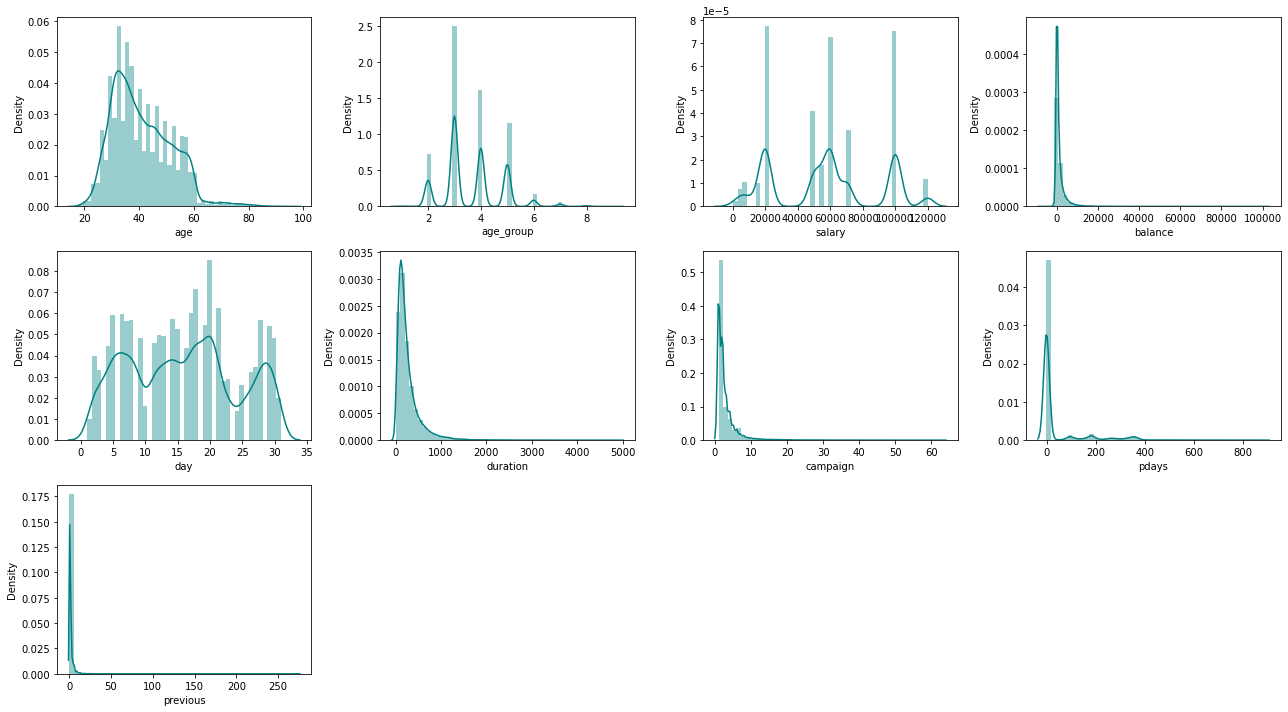

In [16]:
idf = df.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 10))
for index in range(0, len(cols)):
    plt.subplot(3, len(cols)/2, index+1)
    sns.distplot(df[cols[index]], color='teal')
    plt.tight_layout()

plt.show();


#### Count Plot For Categorical Features

In [17]:
idf = df.select_dtypes(include='object')
cols = idf.columns.to_list()

more_group = []
less_group = []
binary_group = []
for col in cols:
    if (len(df[col].unique().tolist()) <= 2):
        binary_group.append(col)
    elif (len(df[col].unique().tolist()) <= 5):
        less_group.append(col)
    else:
        more_group.append(col)


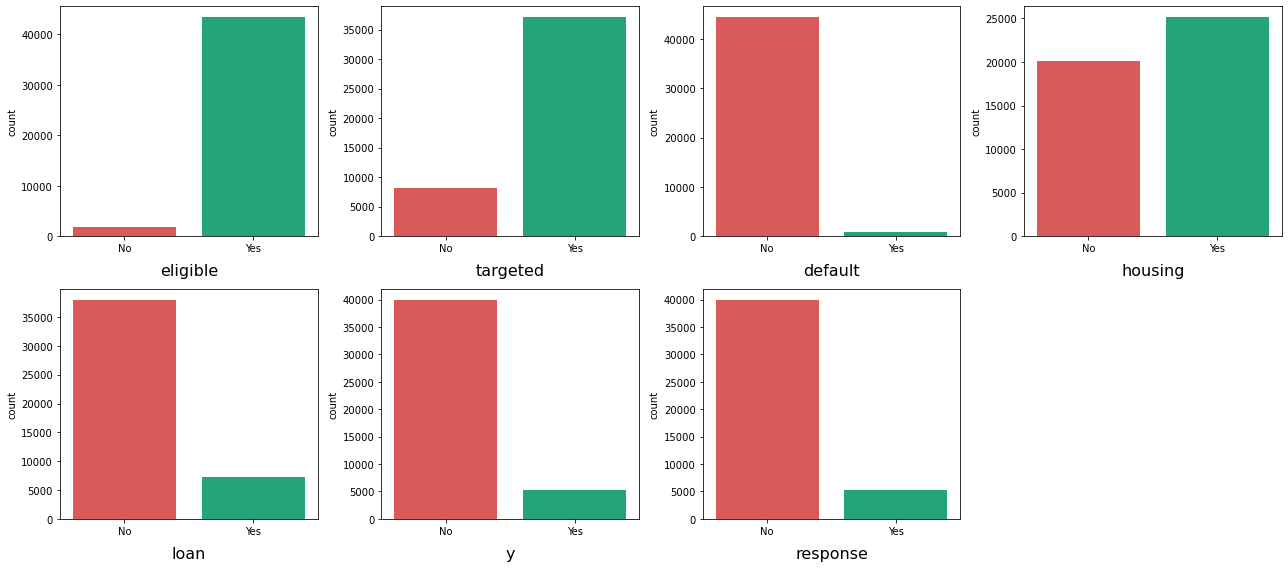

In [18]:
plt.figure(figsize=(18, 8))
for index in range(0, len(binary_group)):
    plt.subplot(len(binary_group) / 3, 4, index+1)
    sns.countplot(df[binary_group[index]], color='teal', orient='v', palette=binary_pallete, order=binary_order)
    plt.tight_layout()
    plt.xlabel(binary_group[index], fontsize='16', labelpad=10)
    # plt.ylabel('Count', fontsize='16')

plt.show();


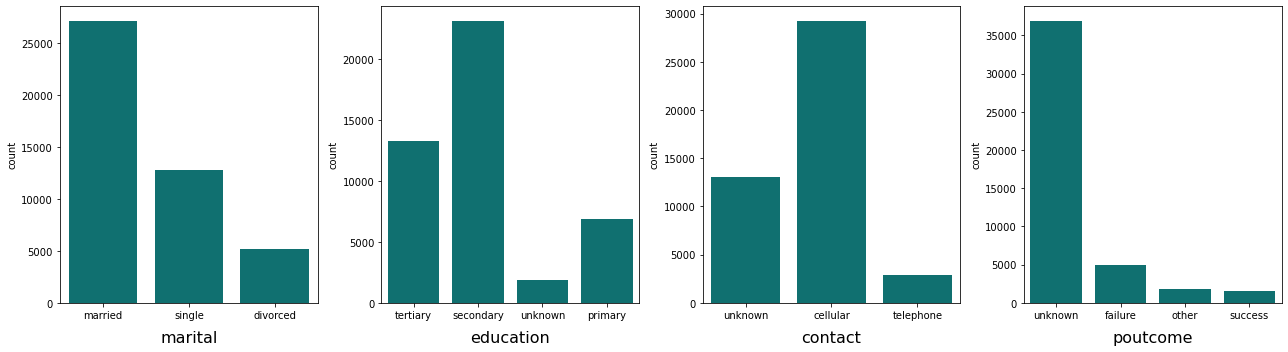

In [19]:
plt.figure(figsize=(18, 5))
for index in range(0, len(less_group)):
    plt.subplot(len(less_group) / 3, 4, index+1)
    sns.countplot(df[less_group[index]], color='teal', orient='v')
    plt.tight_layout()
    plt.xlabel(less_group[index], fontsize='16', labelpad=10)

plt.show();


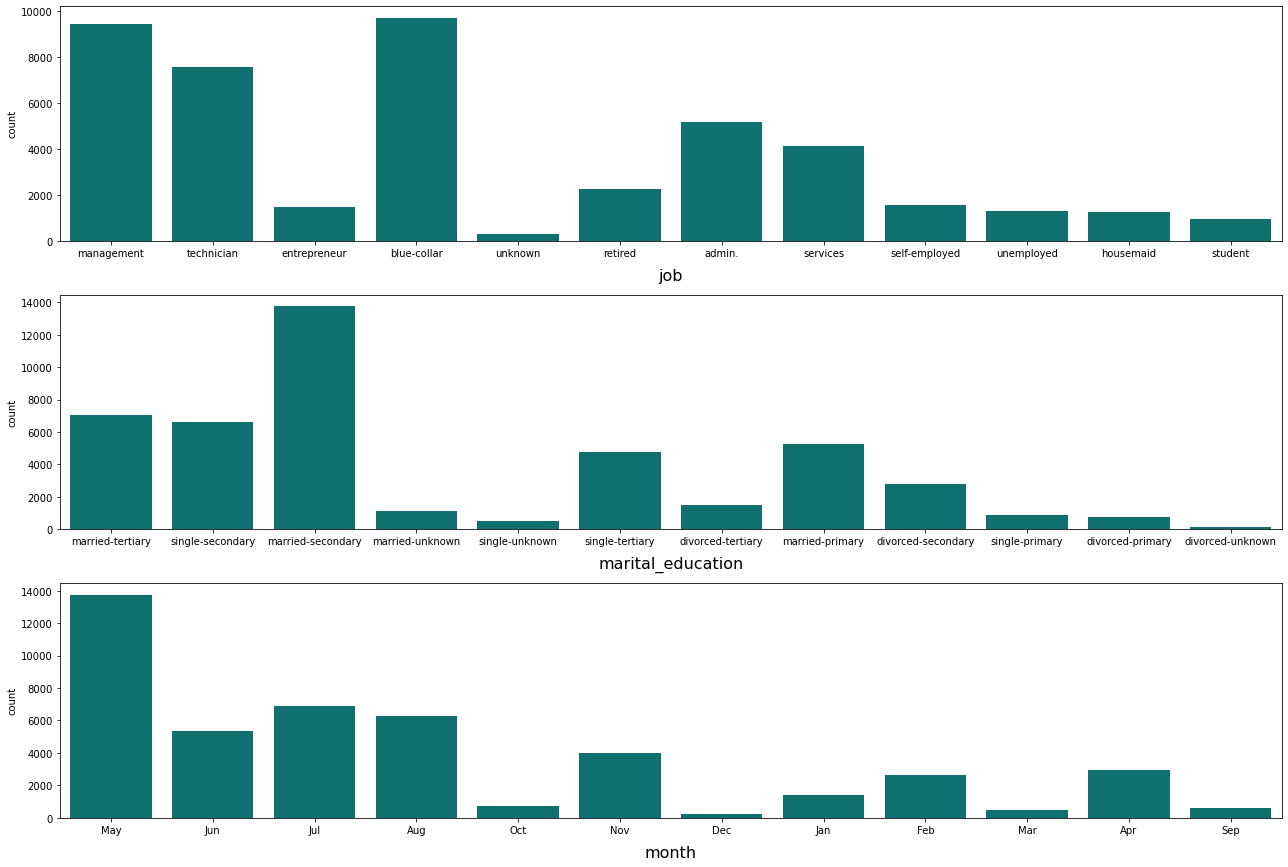

In [20]:
plt.figure(figsize=(18, 12))
for index in range(0, len(more_group)):
    plt.subplot(len(more_group), 1, index+1)
    sns.countplot(df[more_group[index]], color='teal', orient='v')
    plt.tight_layout()
    plt.xlabel(more_group[index], fontsize='16', labelpad=10)

plt.show();


### Multivariate Analysis

#### Correlation Heatmap

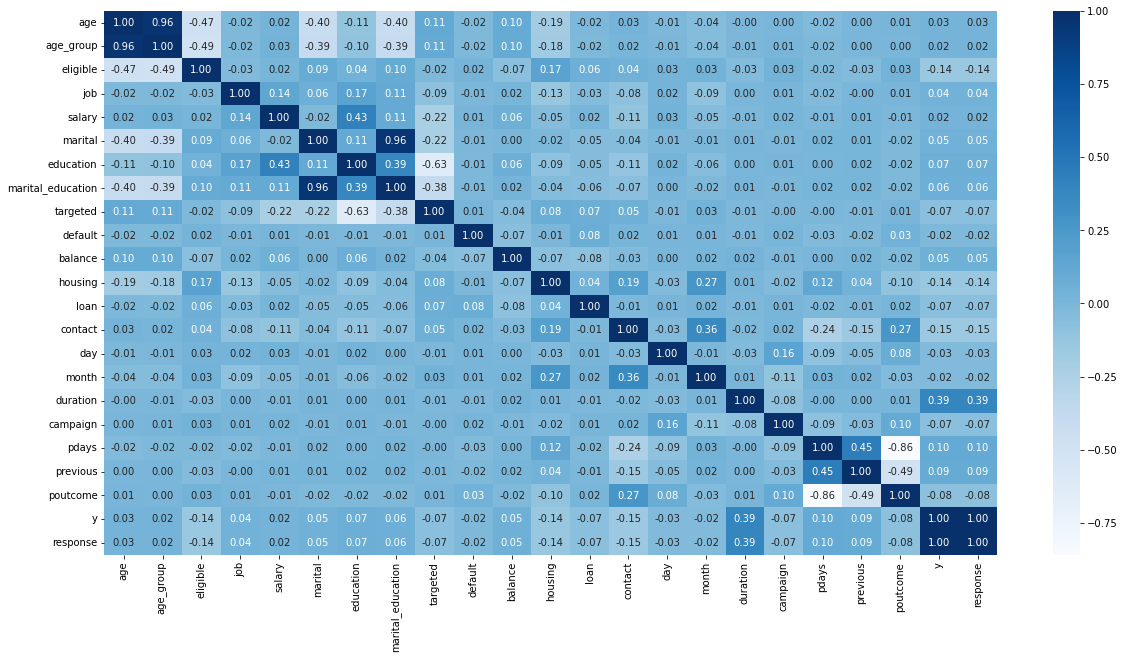

In [21]:
# label encoding for heatmap
edf = df.copy()
for feature in edf.select_dtypes(include='object').columns.tolist():
    edf[feature] = edf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(edf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();


- **response** and **y** has perfect correlation, they could be the same thing
- **age** and **age_group** almost identical, because of strong correlation
- **marital** and **marital_education** almost identical, because of strong correlation

#### Pairplot

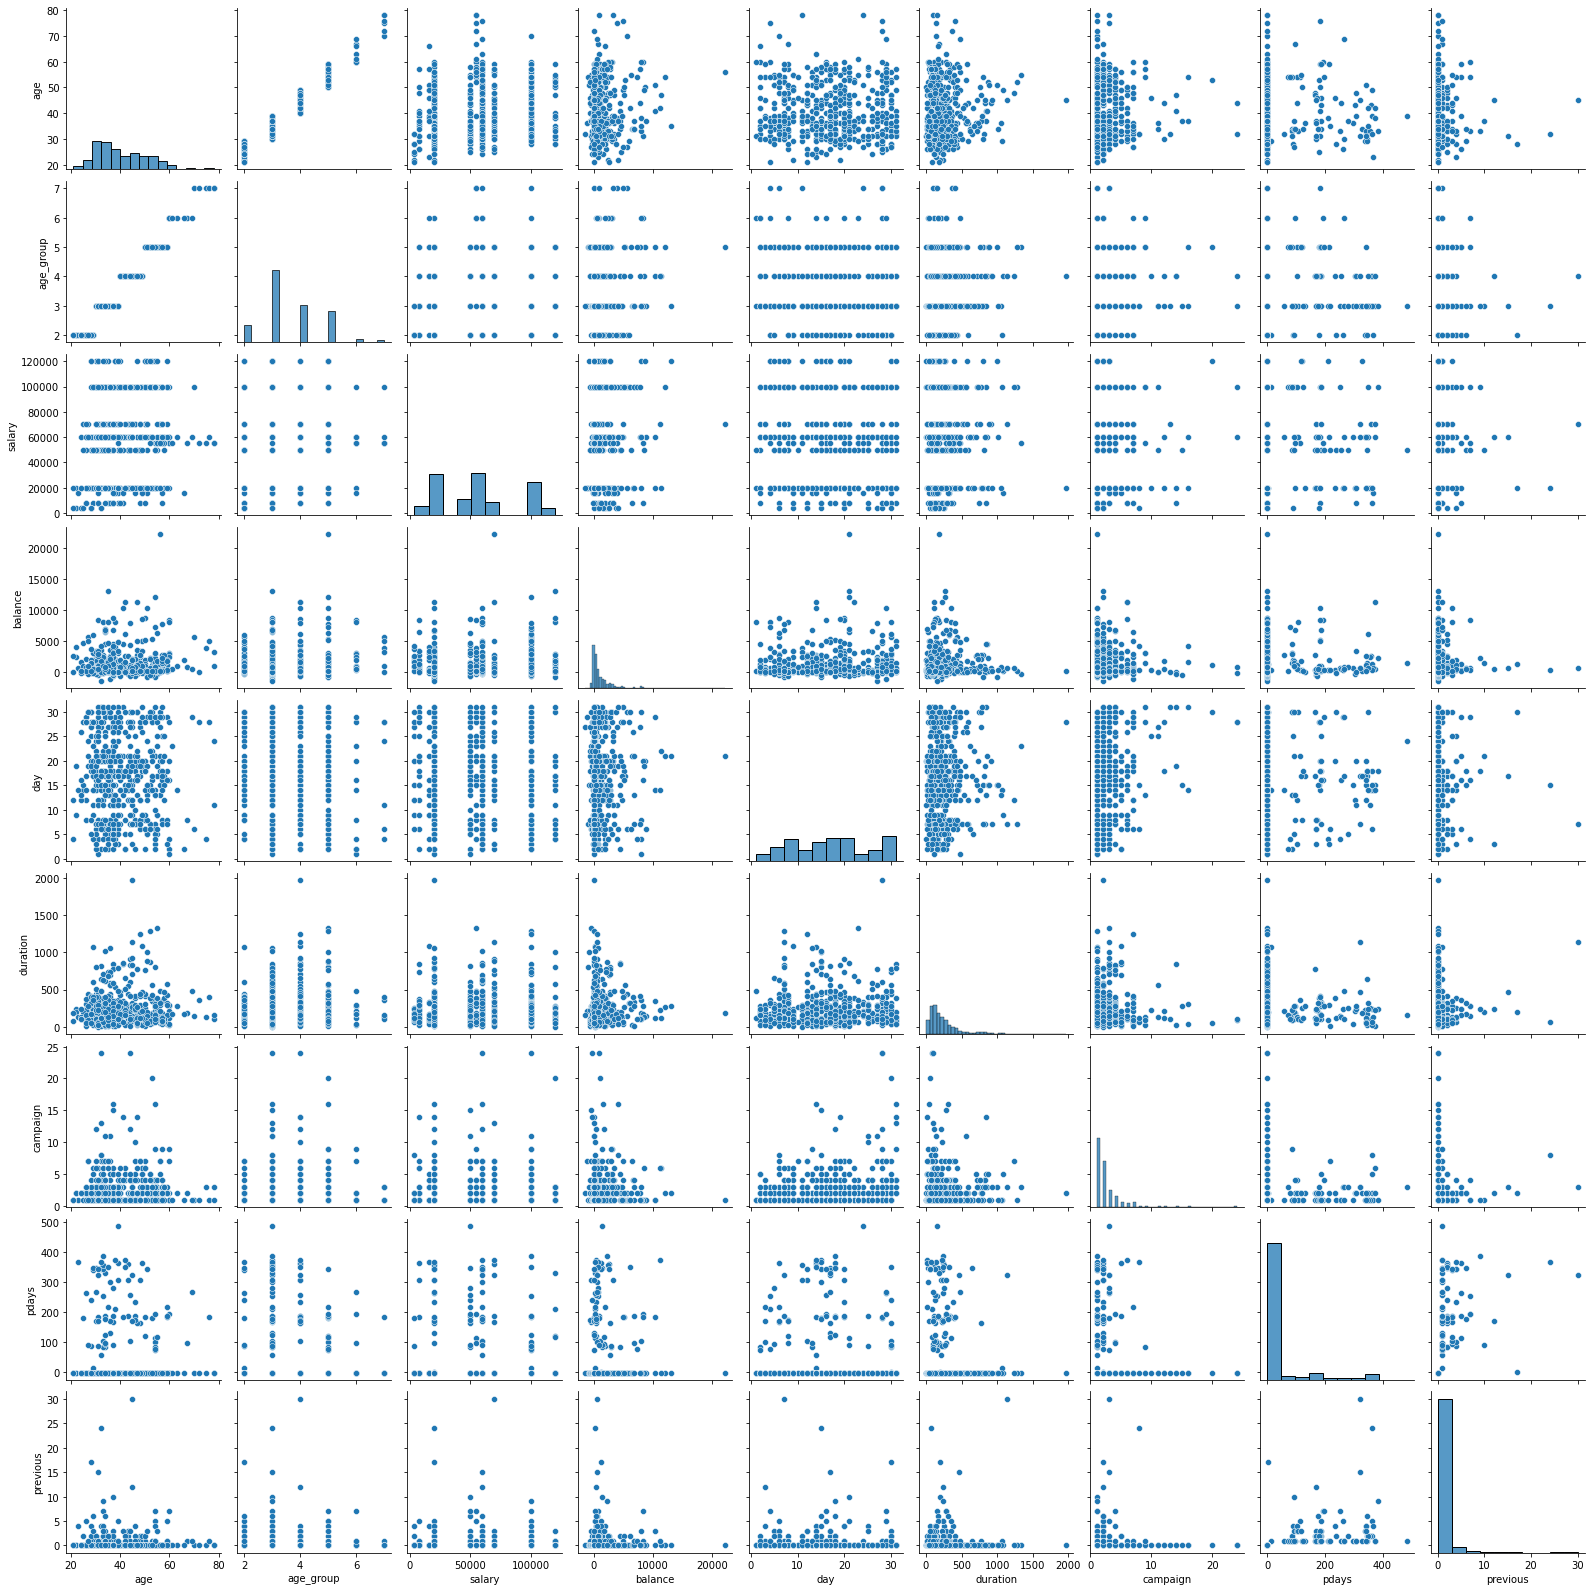

In [22]:
sns.pairplot(data=df.select_dtypes(include='number').sample(500, random_state=1))
plt.show();

### Insights

#### Response Imbalance

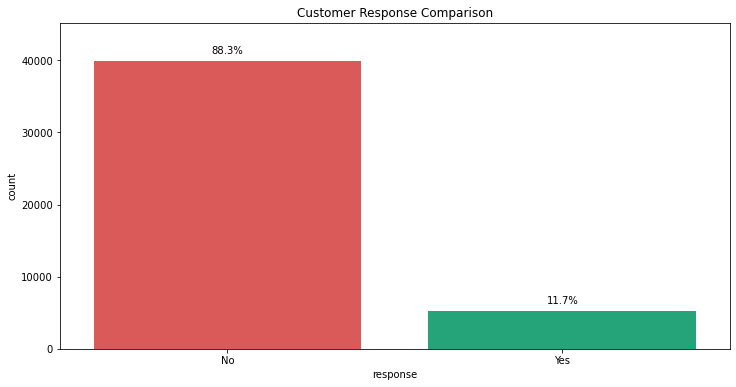

In [23]:
idf = df.groupby(['response']).agg({'response': 'count'}).rename(columns={'response': 'count'}).reset_index()
idf['percentage'] = idf['count'].apply(lambda x: round(x / idf['count'].sum(), 3) * 100)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='response',
    y='count',
    palette=binary_pallete,
    data=idf
)

plt.title('Customer Response Comparison')
plt.ylim((0, idf['count'].sum()))

for index, row in idf.iterrows():
    plt.text(x=index, y=row['count'] + 1000, s=f"{str(round(row['percentage'], 3))}%", ha='center')

plt.show();

- There is a class imbalance for the target feature which can cause the prediction model innacurrate when prediction the minor class response. We can tackle this problem using `oversampling` or `undersampling` later.

#### Duration Distribution with Response

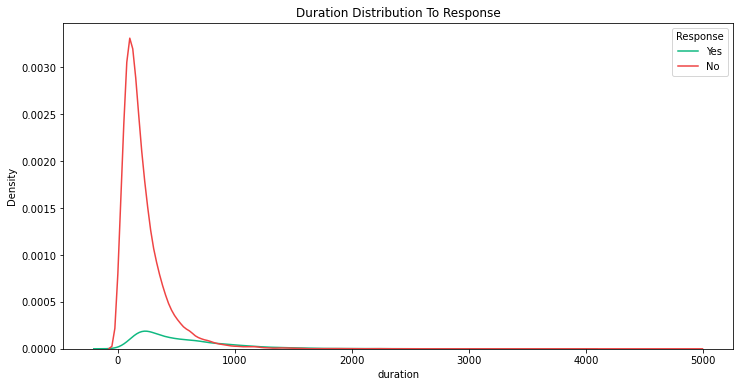

In [24]:
plt.figure(figsize=(12, 6))
sns.kdeplot(
    x='duration', 
    hue='response', 
    palette=binary_pallete,
    data=df
)
plt.title('Duration Distribution To Response')
legend = plt.legend(labels=['Yes', 'No'])
legend.set_title('Response')
plt.show();


#### Previous Outcome Comparison with Response

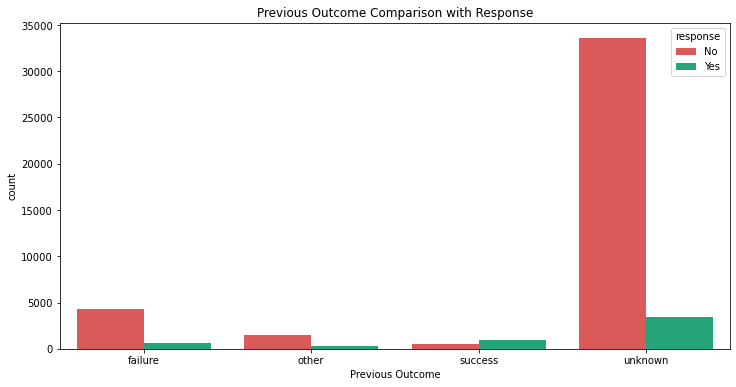

In [25]:
idf = df.groupby(['poutcome','response']).agg({'response': 'count'}).rename(columns={'response': 'count'}).reset_index()
idf = idf.merge(
    df.groupby(['poutcome']).agg('count').rename(columns={'age': 'total_count'}).reset_index()[['poutcome', 'total_count']],
    on='poutcome'
)
idf['percentage'] = idf['count'] / idf['total_count']

idf

plt.figure(figsize=(12, 6))
sns.barplot(x='poutcome', y='count', hue='response', palette=binary_pallete, data=idf)
plt.xlabel('Previous Outcome')

# TODO: find how to properly add text on hue barplot
# current_group = 0
# temp_label = []
# for index, row in idf.iterrows():
#     temp_label.append(str(round(row['percentage'] * 100, 2)) + '%')
#     if (index % 2 == 1):
#         plt.text(x=current_group, y=row['count'] + 1000, s="                  ".join(temp_label), ha='center')
#         current_group = current_group + 1
#         temp_label = []

plt.title('Previous Outcome Comparison with Response')
plt.show();


## Feature Engineering

### Outlier Removal

In [26]:
current = int(df.shape[0])
print("rows count before:", current, '\n')

number_cols = df.select_dtypes(include='number').columns.tolist()

total_reducted = 0
for col in number_cols:
    df = remove_outlier_iqr(df, col)
    reducted = current - int(df.shape[0])
    print(f"- {col}:", reducted)
    total_reducted = total_reducted + reducted
    current = current - reducted

print(f"total: {total_reducted}")
print("\nrows count after:", current)


rows count before: 45211 

- age: 487
- age_group: 1344
- salary: 0
- balance: 4571
- day: 0
- duration: 2807
- campaign: 2532
- pdays: 6190
- previous: 0
total: 17931

rows count after: 27280


### Feature Selection

#### Remove Unnecessary Features

In [27]:
df.drop('y', axis=1, inplace=True)

#### Remove Homogeneous Features

In [28]:
before = df.columns.to_list();
print('before:', before)

removed = []
for col in before:
    if (len(df[col].unique().tolist()) < 2):
        df.drop(col, axis=1, inplace=True)
        removed.append(col)

print('\nremoved:', removed)

after = df.columns.to_list()
print('\nafter:', after)

before: ['age', 'age_group', 'eligible', 'job', 'salary', 'marital', 'education', 'marital_education', 'targeted', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'response']

removed: ['eligible', 'pdays', 'previous', 'poutcome']

after: ['age', 'age_group', 'job', 'salary', 'marital', 'education', 'marital_education', 'targeted', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'response']


### Feature Encoding

#### [For Deployment] Persist The Min-Max Limit of Numerical Features

In [29]:
numerical_limits = {}
for col in df.select_dtypes(include='number').columns.tolist():
    numerical_limits[col] = [df[col].min(), df[col].max()]

pickle.dump(numerical_limits, open('numerical_limits.pickle', 'wb'))

#### Perform Label Encoding For Categorical Features

In [30]:
cols = df.select_dtypes(include='object').columns.tolist()

print("before encoding:")
df[cols].sample(10, random_state=1)

categorical_pickle = {}

for col in cols:

    encoded_data, mapping_index = pd.Series(df[col].sort_values().unique().tolist()).factorize()
    map = dict(zip(mapping_index.to_list(), encoded_data.tolist()))
    df[col] = df[col].apply(lambda value: map[value])
    categorical_pickle[col] = map

print("after encoding:")
df[cols].sample(10, random_state=1)

pickle.dump(categorical_pickle, open('categorical.pickle', 'wb'))


before encoding:


,job,marital,education,marital_education,targeted,default,housing,loan,contact,month,response
2281,entrepreneur,single,tertiary,single-tertiary,No,No,Yes,No,unknown,May,No
42651,technician,single,tertiary,single-tertiary,No,No,Yes,No,unknown,Jan,No
5091,management,single,tertiary,single-tertiary,No,No,Yes,Yes,unknown,May,No
24773,management,married,tertiary,married-tertiary,Yes,No,Yes,No,cellular,Nov,No
24809,technician,single,tertiary,single-tertiary,No,No,Yes,Yes,cellular,Nov,No
20819,technician,married,secondary,married-secondary,Yes,No,No,No,cellular,Aug,No
37310,blue-collar,divorced,unknown,divorced-unknown,No,No,Yes,No,cellular,May,No
37608,blue-collar,divorced,secondary,divorced-secondary,Yes,No,No,No,cellular,May,No
26370,technician,married,secondary,married-secondary,Yes,No,No,No,cellular,Nov,No
44494,blue-collar,married,secondary,married-secondary,Yes,No,Yes,No,cellular,Aug,Yes


after encoding:


,job,marital,education,marital_education,targeted,default,housing,loan,contact,month,response
2281,2,2,2,10,0,0,1,0,2,8,0
42651,9,2,2,10,0,0,1,0,2,4,0
5091,4,2,2,10,0,0,1,1,2,8,0
24773,4,1,2,6,1,0,1,0,0,9,0
24809,9,2,2,10,0,0,1,1,0,9,0
20819,9,1,1,5,1,0,0,0,0,1,0
37310,1,0,3,3,0,0,1,0,0,8,0
37608,1,0,1,1,1,0,0,0,0,8,0
26370,9,1,1,5,1,0,0,0,0,9,0
44494,1,1,1,5,1,0,1,0,0,1,1


### Feature Scaling

#### Current Distribution State

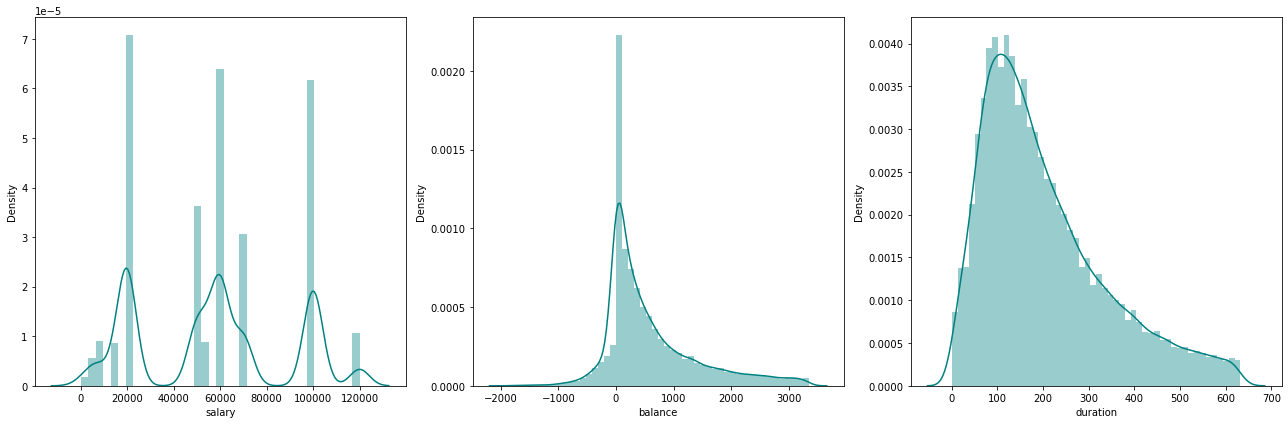

In [31]:
idf = df.select_dtypes(include='number')
cols = ['salary', 'balance', 'duration']

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(df[cols[index]], color='teal')
    plt.tight_layout()

plt.show();


Since the three features doesn't have normal/gaussian distribution, we will perform `Normalization`/`MinMaxScaler` to the features instead of `Standardization`.

#### Scaling

In [32]:
from sklearn.preprocessing import MinMaxScaler
cols = ['salary', 'balance', 'duration']

print("before scaling:")
df[cols].sample(5, random_state=1)

for col in cols:
    scaler = MinMaxScaler().fit(df[col].values.reshape(len(df), 1))
    df[col] = scaler.transform(df[col].values.reshape(len(df), 1))
    pickle.dump(scaler, open('scaler_' + col + '.pickle', 'wb'))


print("after scaling:")
df[cols].sample(5, random_state=1)


before scaling:


,salary,balance,duration
2281,120000,714,166
42651,60000,434,127
5091,100000,-867,222
24773,100000,1613,95
24809,60000,172,52


after scaling:


,salary,balance,duration
2281,1.000000,0.496940,0.262658
42651,0.500000,0.443382,0.200949
5091,0.833333,0.194529,0.351266
24773,0.833333,0.668898,0.150316
24809,0.500000,0.393267,0.082278


## Modeling

### Split Data for Train, Test and Validation

#### Defining the Predictors and Target

In [33]:
predictors = df.loc[:, ~df.columns.isin(['response'])]
target = df[['response']]

print("predictors:", predictors.columns.tolist())
print("\ntarget:", target.columns.tolist())


predictors: ['age', 'age_group', 'job', 'salary', 'marital', 'education', 'marital_education', 'targeted', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign']

target: ['response']


#### Split Data Into Train and Test

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2, random_state = 1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1)

pd.DataFrame({
    'x_train': [x_train.shape],
    'x_test': [x_test.shape],
    'x_val': [x_val.shape],
    'y_train': [y_train.shape],
    'y_test': [y_test.shape],
    'y_val': [y_val.shape],
})


,x_train,x_test,x_val,y_train,y_test,y_val
0,"(21824, 17)","(2728, 17)","(2728, 17)","(21824, 1)","(2728, 1)","(2728, 1)"


#### Perform Oversampling on Data Train

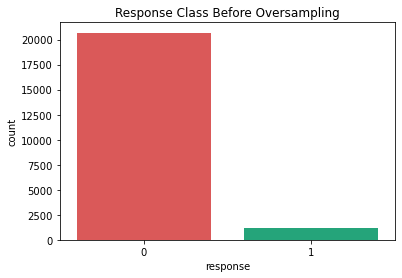

In [35]:
sns.countplot(pd.concat([x_train, y_train], axis=1)['response'], orient='v', palette=binary_pallete)
plt.title('Response Class Before Oversampling')
plt.show();

In [36]:
from imblearn import over_sampling
x_train, y_train = over_sampling.SMOTE(0.5, random_state=1).fit_resample(x_train, y_train)

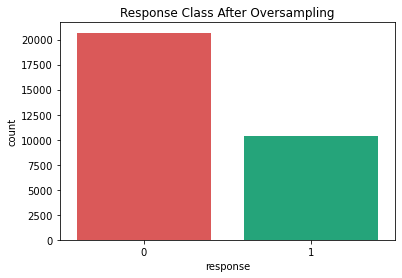

In [37]:
sns.countplot(pd.concat([x_train, y_train], axis=1)['response'], orient='v', palette=binary_pallete)
plt.title('Response Class After Oversampling')
plt.show();

### Model Training

#### DecisionTree Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

#### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=1)
logistic_regression.fit(x_train, y_train)

LogisticRegression(random_state=1)

#### ExtraTree Classifier

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
extratree_classifier = ExtraTreesClassifier(random_state=1)
extratree_classifier.fit(x_train, y_train)

ExtraTreesClassifier(random_state=1)

#### K-NearestNeighbors Classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train, y_train)


KNeighborsClassifier()

#### XGBoost Classifier

In [42]:
from xgboost import XGBClassifier
xg_classifier = XGBClassifier(random_state=1)
xg_classifier.fit(x_train, y_train)

[04:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Model Evaluation

#### Evaluation on Test Data (True & False)

In [43]:
eval_decision_tree = eval_classification(decision_tree.predict(x_test), y_test)
eval_logistic_regression = eval_classification(logistic_regression.predict(x_test), y_test)
eval_extratree_classifier = eval_classification(extratree_classifier.predict(x_test), y_test)
eval_knn_classifier = eval_classification(knn_classifier.predict(x_test), y_test)
eval_xg_classifier = eval_classification(xg_classifier.predict(x_test), y_test)

pd.DataFrame({
    'DecisionTree Classifier': eval_decision_tree,
    'Logistic Regression': eval_logistic_regression,
    'ExtraTree Classifier': eval_extratree_classifier,
    'K-NearestNeighbors Classifier': eval_knn_classifier,
    'XGBoost Classifier': eval_xg_classifier,
}).transpose()


,accuracy,precision,recall
DecisionTree Classifier,0.89,0.23,0.47
Logistic Regression,0.88,0.22,0.59
ExtraTree Classifier,0.94,0.36,0.35
K-NearestNeighbors Classifier,0.87,0.16,0.36
XGBoost Classifier,0.94,0.39,0.45


#### Evaluation on Test Data (True Only)

In [44]:
y_test_true = y_test[y_test['response'] == 1]
x_test_true = x_test.loc[y_test_true.index]

eval_true_decision_tree = eval_classification(decision_tree.predict(x_test_true), y_test_true)
eval_true_logistic_regression = eval_classification(logistic_regression.predict(x_test_true), y_test_true)
eval_true_extratree_classifier = eval_classification(extratree_classifier.predict(x_test_true), y_test_true)
eval_true_knn_classifier = eval_classification(knn_classifier.predict(x_test_true), y_test_true)
eval_true_xg_classifier = eval_classification(xg_classifier.predict(x_test_true), y_test_true)

pd.DataFrame({
    'DecisionTree Classifier': eval_true_decision_tree,
    'Logistic Regression': eval_true_logistic_regression,
    'ExtraTree Classifier': eval_true_extratree_classifier,
    'K-NearestNeighbors Classifier': eval_true_knn_classifier,
    'XGBoost Classifier': eval_true_xg_classifier,
}).transpose()

,accuracy,precision,recall
DecisionTree Classifier,0.47,1.0,0.47
Logistic Regression,0.59,1.0,0.59
ExtraTree Classifier,0.35,1.0,0.35
K-NearestNeighbors Classifier,0.36,1.0,0.36
XGBoost Classifier,0.45,1.0,0.45


#### Evaluation on Test Data (False Only)

In [45]:
y_test_false = y_test[y_test['response'] == 0]
x_test_false = x_test.loc[y_test_false.index]

eval_false_decision_tree = eval_classification(decision_tree.predict(x_test_false), y_test_false)
eval_false_logistic_regression = eval_classification(logistic_regression.predict(x_test_false), y_test_false)
eval_false_extratree_classifier = eval_classification(extratree_classifier.predict(x_test_false), y_test_false)
eval_false_knn_classifier = eval_classification(knn_classifier.predict(x_test_false), y_test_false)
eval_false_xg_classifier = eval_classification(xg_classifier.predict(x_test_false), y_test_false)

pd.DataFrame({
    'DecisionTree Classifier': eval_false_decision_tree,
    'Logistic Regression': eval_false_logistic_regression,
    'ExtraTree Classifier': eval_false_extratree_classifier,
    'K-NearestNeighbors Classifier': eval_false_knn_classifier,
    'XGBoost Classifier': eval_false_xg_classifier,
}).transpose()

,accuracy,precision,recall
DecisionTree Classifier,0.92,0.0,0.0
Logistic Regression,0.89,0.0,0.0
ExtraTree Classifier,0.97,0.0,0.0
K-NearestNeighbors Classifier,0.90,0.0,0.0
XGBoost Classifier,0.96,0.0,0.0


### Validation

In [46]:
val_decision_tree = eval_classification(decision_tree.predict(x_val), y_val)
val_logistic_regression = eval_classification(logistic_regression.predict(x_val), y_val)
val_extratree_classifier = eval_classification(extratree_classifier.predict(x_val), y_val)
val_knn_classifier = eval_classification(knn_classifier.predict(x_val), y_val)
val_xg_classifier = eval_classification(xg_classifier.predict(x_val), y_val)

pd.DataFrame({
    'DecisionTree Classifier': val_decision_tree,
    'Logistic Regression': val_logistic_regression,
    'ExtraTree Classifier': val_extratree_classifier,
    'K-NearestNeighbors Classifier': val_knn_classifier,
    'XGBoost Classifier': val_xg_classifier,
}).transpose()

,accuracy,precision,recall
DecisionTree Classifier,0.89,0.19,0.40
Logistic Regression,0.87,0.18,0.50
ExtraTree Classifier,0.93,0.30,0.29
K-NearestNeighbors Classifier,0.87,0.16,0.40
XGBoost Classifier,0.94,0.35,0.40


## Model Deployment (Simulation) 

### Persist Model to Disk

In [47]:
pickle.dump(logistic_regression, open('model.pickle', 'wb'))

### Test The Persisted Model

#### Test using Data Validation Sample

In [48]:
model = pickle.load(open('model.pickle', 'rb'))

outputs = y_val[y_val['response'] == 1].sample(15, random_state=1)
inputs = x_val.loc[outputs.index]
prediction = model.predict(inputs)

pd.DataFrame({
    'prediction': prediction.tolist(),
    'actual': outputs['response'].tolist()
})


,prediction,actual
0,0,1
1,1,1
2,0,1
3,1,1
4,1,1
5,0,1
6,1,1
7,0,1
8,0,1
9,0,1


#### Test using Raw Input

In [49]:
# load encoder/decoder and scaler
salary_scaler = pickle.load(open('scaler_salary.pickle', 'rb'))
balance_scaler = pickle.load(open('scaler_balance.pickle', 'rb'))
duration_scaler = pickle.load(open('scaler_duration.pickle', 'rb'))
categorical_encoder = pickle.load(open('categorical.pickle', 'rb'))
numerical_mapper = pickle.load(open('numerical_limits.pickle', 'rb'))
response_decoder = {v: k for k, v in categorical_encoder['response'].items()}

# raw inputs
age = 31
age_group = 3
job = "technician"
salary = 60000
marital = "married"
education = "secondary"
marital_education = "married-secondary"
targeted = 'Yes'
default = 'No'
balance = 183
housing = 'No'
loan = 'No'
contact = 'cellular'
day = 16
month = "Apr"
duration = 495
campaign = 1

# transformed inputs for model
inputs = pd.DataFrame({
    'age': [age],
    'age_group': [age_group],
    'job': [categorical_encoder['job'][job]],
    'salary': [salary_scaler.transform(np.array([salary]).reshape(1, -1))[0][0]],
    'marital': [categorical_encoder['marital'][marital]],
    'education': [categorical_encoder['education'][education]],
    'marital_education': [categorical_encoder['marital_education'][marital_education]],
    'targeted': [categorical_encoder['targeted'][targeted]],
    'default': [categorical_encoder['default'][default]],
    'balance': [balance_scaler.transform(np.array([balance]).reshape(1, -1))[0][0]],
    'housing': [categorical_encoder['housing'][housing]],
    'loan': [categorical_encoder['loan'][loan]],
    'contact': [categorical_encoder['contact'][contact]],
    'day': [day],
    'month': [categorical_encoder['month'][month]],
    'duration': [duration_scaler.transform(np.array([duration]).reshape(1, -1))[0][0]],
    'campaign': [campaign],
})

# predict
output = model.predict(inputs)
response_decoder[output[0]]


'Yes'